In [1]:
import gensim
from gensim.models import Word2Vec
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False)

In [35]:
model.most_similar(['rock'])

[('indie', 0.6529097557067871),
 ('punk', 0.6498284935951233),
 ('pop', 0.6095801591873169),
 ('band', 0.6057138442993164),
 ('grunge', 0.6026045680046082),
 ('metal', 0.5947062969207764),
 ('folk', 0.567721962928772),
 ('rockabilly', 0.5619145631790161),
 ('bands', 0.5610542297363281),
 ('synthpop', 0.5544852614402771)]

In [32]:
model.most_similar(['', 'england'], ['america'])

[('nottinghamshire', 0.40037858486175537),
 ('warwickshire', 0.397294819355011),
 ('mixtecs', 0.3770623207092285),
 ('aztec', 0.3762865662574768),
 ('gloucestershire', 0.37138208746910095),
 ('worcestershire', 0.3703794777393341),
 ('northamptonshire', 0.36693239212036133),
 ('leicestershire', 0.36681750416755676),
 ('tlatoani', 0.36521801352500916),
 ('leicester', 0.3631800711154938)]

In [43]:
model.most_similar(['grothendieck '])

KeyError: "word 'grothendieck ' not in vocabulary"

In [42]:
model.most_similar(['kolmogorov', 'topology'], ['probability'])

[('topologies', 0.5512890219688416),
 ('manifolds', 0.5251404047012329),
 ('invariants', 0.4976772665977478),
 ('topological', 0.49455025792121887),
 ('hilbert', 0.4756934940814972),
 ('pontryagin', 0.468117356300354),
 ('tychonoff', 0.4634854793548584),
 ('grothendieck', 0.44825324416160583),
 ('riemannian', 0.44656234979629517),
 ('hausdorff', 0.4454619586467743)]

In [3]:
model.most_similar(positive=['novorossiysk', 'ukraine'], negative=['russia'])

[('mariupol', 0.6894228458404541),
 ('kharkiv', 0.625602662563324),
 ('sevastopol', 0.6135071516036987),
 ('zaporizhya', 0.6019512414932251),
 ('odessa', 0.5999424457550049),
 ('kherson', 0.5955302715301514),
 ('dnipropetrovsk', 0.5812416672706604),
 ('donetsk', 0.5733100771903992),
 ('kyiv', 0.5717471837997437),
 ('mykolaiv', 0.568718671798706)]

## data

In [2]:
def produce_data(filename):
    file = open(filename)
    sentences = []
    pos = []
    labels = []
    sentence, sentence_pos, sentence_labels = [], [], []
    
    for entry in file:
        if len(entry.split(' ')) == 1:
            sentences.append(sentence)
            labels.append(sentence_labels)
            pos.append(sentence_pos)
            sentence, sentence_pos, sentence_labels = [], [], []
        else:
            word, word_pos, word_label = entry.split(' ')
            sentence.append(word.lower())
            sentence_pos.append(word_pos)
            sentence_labels.append(word_label[0])
    file.close()
    return sentences, pos, labels

def produce_vectors(sentences, w2v):
    vectors, sentence_vectors = [], []
    for sentence in sentences:
        for word in sentence:
            try:
                vector = w2v[word]
            except:
                vector = np.zeros((300))
            sentence_vectors.append(vector)
        vectors.append(sentence_vectors)
    return vectors

def find_in_list(lst, elem):
    try:
        return(lst.index(elem))
    except:
        return 0

def process_pos(pos, pos_set=None):
    if pos_set is None:
        pos_set = list(set([elem for sentence in pos for elem in sentence]))
        pos_set = ["Unknown"] + pos_set
    pos_indexed = [[find_in_list(pos_set, elem) for elem in sentence] for sentence in pos]
    pos_onehot = []
    for sentence in pos_indexed:
        sentence_onehot = []
        for word in sentence:
            word_onehot = np.zeros((len(pos_set)))
            word_onehot[word] = 1.
            sentence_onehot.append(word_onehot)
        pos_onehot.append(sentence_onehot)
    return pos_onehot, pos_set

def process_labels(labels):
    new_labels = []
    for sentence in labels:
        sentence_labels = []
        for word in sentence:
            if word == 'B':
                word_label = 0
            if word == 'I':
                word_label = 1
            if word == 'O':
                word_label = 2
            sentence_labels.append(word_label)
        sentence_labels = np.array(sentence_labels)
        new_labels.append(sentence_labels)
    return new_labels

def concat_features(vectors, one_hot):
    new_features = []
    for v_sentence, p_sentence in list(zip(vectors, one_hot)):
        sentence_features = []
        for v_word, p_word in list(zip(v_sentence, p_sentence)):
#             print(p_word.shape)
#             print(v_word.shape)
            word_features = np.concatenate([v_word, p_word])[None, :]
            sentence_features.append(word_features)
        sentence_features = np.concatenate(sentence_features)
        new_features.append(sentence_features)
    return new_features

In [31]:
# sentences, pos, labels = produce_data('train.txt')
sentences, pos, labels = produce_data('test.txt')

In [32]:
from collections import defaultdict
import operator
 

In [33]:
words = defaultdict(int)
for sentence in sentences:
    for word in sentence:
        words[word]+=1
words = dict(words)

In [4]:
def prepare_data(filename, model, pos_set=None):
    sentences, pos, labels = produce_data(filename)
    vectors = produce_vectors(sentences, model)
    pos_onehot, pos_set = process_pos(pos, pos_set)
    indexed_labels = process_labels(labels)
#     return pos_onehot
    features = concat_features(vectors, pos_onehot)
    return features, indexed_labels, pos_set

In [18]:
def pad(x, y):
    maxlen = np.max([seq.shape[0] for seq in x])
    D = x[0].shape[1]
    padded_x = []
    padded_y = []
    seq_lens = []
    for seq, labels in list(zip(x, y)):
        seq_len = seq.shape[0]
        padded_seq = np.concatenate([seq, np.zeros((maxlen - seq_len, D))])[None, :, :]
        padded_labels = np.concatenate([labels, np.zeros((maxlen - seq_len))])[None, :]
        padded_x.append(padded_seq)
        padded_y.append(padded_labels)
        seq_lens.append(seq_len)
    return np.concatenate(padded_x), np.concatenate(padded_y), np.array(seq_lens)

In [436]:
def make_classification_data(x, y):
    x_new, y_new = [], []
    for seq, labels in list(zip(x, y)):
        x_new.append(seq)
        y_new.append(labels)
    x_new = np.concatenate(x_new)
    y_new = np.concatenate(y_new)
#     y_new[y_new == 1] = 0
#     y_new[y_new == 2] = 1
    return x_new, y_new

### Classification data

In [437]:
# x_tr, y_tr, pos_set = prepare_data('train.txt', model)
x_te, y_te, _ = prepare_data('test.txt', model)
x_tr, y_tr = x_te[:500], y_te[:500]
x_te, y_te = x_te[500:], y_te[500:]

In [438]:
x_te, y_te = make_classification_data(x_te, y_te)
x_tr, y_tr = make_classification_data(x_tr, y_tr)

In [440]:
np.save('data_class/x_tr', x_tr[:, 300:])
np.save('data_class/x_te', x_te[:, 300:])
np.save('data_class/y_tr', y_tr)
np.save('data_class/y_te', y_te)

### Structured Prediction data

In [441]:
# x_tr, y_tr, pos_set = prepare_data('train.txt', model)
x_te, y_te, _ = prepare_data('test.txt', model)
x_tr, y_tr = x_te[:500], y_te[:500]
x_te, y_te = x_te[500:], y_te[500:]

In [442]:
x_te, y_te, seq_lens_te = pad(x_te, y_te)
x_tr, y_tr, seq_lens_tr = pad(x_tr, y_tr)

In [443]:
x_te = x_te[:, :, 300:]
x_tr = x_tr[:, :, 300:]

## Pretrained embedding

In [444]:
P = np.load('P.npy')
d, D = P.shape

In [445]:
x_tr_flat = x_tr.reshape([-1, D])
x_te_flat = x_te.reshape([-1, D])

In [446]:
x_tr_flat = x_tr_flat.dot(P.T)
x_te_flat = x_te_flat.dot(P.T)

In [447]:
x_tr = x_tr_flat.reshape(list(x_tr.shape[:2])+[d])
x_te = x_te_flat.reshape(list(x_te.shape[:2])+[d])

## Training

In [448]:
import numpy as np
import tensorflow as tf
import t3f
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from TTGP.gpstruct import TTGPstruct
from TTGP import grid
from TTGP.covariance import SE_multidim, BinaryKernel
from TTGP.projectors import LinearProjector, Identity
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [449]:
D = x_tr.shape[-1]
# d = 3
n_labels = 3

In [450]:
x_tr_flat = x_tr.reshape([-1, D])
x_te_flat = x_te.reshape([-1, D])

In [451]:
scaler = StandardScaler()
x_tr_flat = scaler.fit_transform(x_tr_flat)/3
x_te_flat = scaler.transform(x_te_flat)/3

In [452]:
x_tr = x_tr_flat.reshape(x_tr.shape)
x_te = x_te_flat.reshape(x_te.shape)

In [453]:
x_tr[x_tr > 1] = 1
x_tr[x_tr < -1] = -1
x_te[x_te > 1] = 1
x_te[x_te < -1] = -1

### GP

In [454]:
tf.reset_default_graph()

In [455]:
num = 10
inputs = grid.InputsGrid(d, left=-1., right=1., npoints=num)
projector = Identity(D)#LinearProjector(d=d, D=D)
cov = SE_multidim(n_labels, .7, .3, .1, projector)
bin_cov = BinaryKernel(n_labels, alpha=1.)

In [456]:
mu_ranks = 10
gp = TTGPstruct(cov, bin_cov, inputs, mu_ranks)

In [457]:
x_tr_ = tf.constant(x_tr)[:150]
x_te_ = tf.constant(x_te)
y_tr_ = tf.constant(y_tr)[:150]
y_te_ = tf.constant(y_te)
seq_lens_tr_ = tf.constant(seq_lens_tr)[:150]
seq_lens_te_ = tf.constant(seq_lens_te)

In [458]:
N = x_tr.shape[0]
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(1e-2, global_step, 
                                        100, 0.5, staircase=True)

In [459]:
elbo_op, train_op = gp.fit(x_tr_, y_tr_, seq_lens_tr_, N, lr, global_step)

_latent_vars_distribution/x_flat (?, 3) = sum_len x 3
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 3
cov_for_squared_dists/cov (3, 150, 63, 63) = [3, 150, 63, 63]
_Knns/K_nn (3, 150, 63, 63) = 3 x 150 x 63 x 63
_sample_f/f_un (3, 150, 63) = 3 150 63
_sample_f/f_bin (9,) = 9


### Learning

In [460]:
sess = tf.Session()
gp.initialize(sess)
sess.run(tf.global_variables_initializer())
elbo_vals = []

In [479]:
maxiter = 100

for i in range(maxiter):
    _, elbo = sess.run([train_op, elbo_op])
    print(i, elbo)
    elbo_vals.append(elbo)

0 8.34904176825
1 15.8860113902
2 12.0954294089
3 7.81000358668
4 12.4225378116
5 10.3286674329
6 2.25711124028
7 -0.308832508652
8 20.7064569928
9 10.9413613692
10 17.5820313
11 17.1742666324
12 24.2399170974
13 7.92467421793
14 3.75781878324
15 19.252897266
16 16.4231671745
17 26.7849475438
18 11.2248837798
19 4.05850785349
20 19.2351359523
21 8.95964015251
22 8.0329966952
23 24.5663304042
24 19.044747158
25 1.59385441767
26 30.6006781436
27 5.22460166951
28 3.79562388261
29 25.892050131
30 29.0067657609
31 3.91378554806
32 7.7449723382
33 13.8967717442
34 19.542231401
35 18.391229126
36 -10.2711358496
37 0.327739652938
38 6.67632270555
39 20.5781245558
40 4.52381138494
41 27.7348119837
42 20.2896644218
43 10.5168307685
44 12.1413651711
45 7.83272447396
46 17.6942156456
47 20.3767598836
48 16.505765591
49 11.0277187147
50 33.9207399777
51 11.5913118857
52 11.2712794142
53 1.88510149538
54 17.8500427895
55 11.7000267644
56 -2.60864761943
57 8.43883997861
58 17.5602643238
59 35.1098272

In [408]:
sess.close()

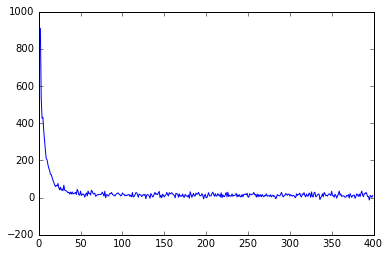

In [480]:
plt.plot(elbo_vals)

Prediction

In [481]:
preds = gp.predict(x_te_, seq_lens_te_, sess)

_latent_vars_distribution/x_flat (?, 3) = sum_len x 3
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 3
cov_for_squared_dists/cov (3, 323, 63, 63) = [3, 323, 63, 63]
_Knns/K_nn (3, 323, 63, 63) = 3 x 323 x 63 x 63


In [482]:
i = 5
y_te[i, :seq_lens_te[i]] == preds[i]

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True], dtype=bool)

0.917265264238


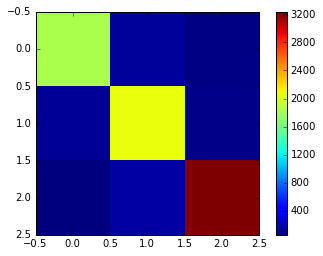

In [483]:
sum = 0
sum_len = 0
confusion_mat = np.zeros((3, 3))
for y, pred in list(zip(y_te, preds)):
    confusion_mat += confusion_matrix(y[:len(pred)], np.array(pred), labels=[0, 1, 2])
    sum += np.sum(y[:len(pred)] == np.array(pred))
    sum_len += len(pred)
print(sum / sum_len)
plt.imshow(confusion_mat, interpolation="Nearest")
plt.colorbar()

In [484]:
(np.sum(confusion_mat[:2, :2]) + confusion_mat[2, 2]) / np.sum(confusion_mat)

0.95061570035915854

In [485]:
m_bin = sess.run(gp.bin_mu)

In [486]:
for i in range(3):
    for j in range(3):
        print(m_bin[3 * i + j], i, j)

-0.832852909495 0 0
1.02096405689 0 1
-0.374723716593 0 2
-0.882030868955 1 0
0.650322429099 1 1
-0.023054763459 1 2
1.01998514801 2 0
-1.28547005235 2 1
0.288276720718 2 2


In [320]:
sess.run(gp.bin_cov.alpha)

4.9847481144547272

In [926]:
sigma_bin_l.shape

(9, 9)

In [ ]:
sigma_bin = sigma_bin_l

In [727]:
y == np.array(pred)

False

In [724]:
pred

[1, 1, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2]

In [ ]:
y_te

In [716]:
len(preds[0])

28

In [710]:
np.sum(y_te == preds) / preds.size

0.0

In [614]:
m_un, S_un, m_bin, S_bin = gp._latent_vars_distribution(x_tr_, seq_lens_tr_)

_latent_vars_distribution/x_flat (?, 339) = sum_len x 339
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 3
cov_for_squared_dists/cov (3, 77, 50, 50) = [3, 77, 50, 50]
_Knns/K_nn (3, 77, 50, 50) = 3 x 77 x 50 x 50


In [611]:

y_te

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  2., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.]])

In [615]:
S_un_ = sess.run(S_un)

In [622]:
S_un_[0, 0, 24, 24]

0.4705951739073676

In [621]:
S_un_[0, 0, 24, 7]

0.4705951739073676

In [665]:
def _compute_chol(seq_lens, cov_mat):

    n_labels, batch_size, max_len, _ = cov_mat.get_shape().as_list()
    sequence_mask = tf.logical_not(tf.sequence_mask(seq_lens, maxlen=max_len))
    sequence_mask = tf.cast(sequence_mask, tf.float64)
    I = tf.eye(max_len, batch_shape=[n_labels, batch_size], dtype=tf.float64)
     # We add ones on diagonals in the meaningless dimensions of covs.
    new_cov_mat = cov_mat + tf.einsum('lsij,si->lsij', I, sequence_mask)
 
         # NOTE: if same word (x) is repeated the matrix becomes singular
         # ugly solution
    new_cov_mat = new_cov_mat + 0.1 * I
 
    return new_cov_mat

In [666]:
ans = sess.run(_compute_chol(seq_lens_tr_, S_un))

In [667]:
np.linalg.det(ans[0, 56])

-7.8457487274626774e-15

In [682]:
np.linalg.det(S_un_[0, 56] +0.5 * np.eye(50))

0.15925627839341569

In [672]:
sess.run(gp.cov.l)

array([ 0.301,  0.301,  0.301])

In [685]:
ans_ = ans[0, 56]
ans_[ans_ < 0] = 0

In [671]:
sess.run(gp.cov.sigma_f)

array([ 0.728,  0.728,  0.728])

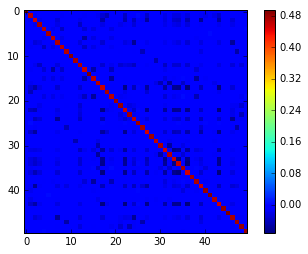

In [668]:
plt.imshow(S_un_[0, 56], interpolation="nearest")
plt.colorbar()

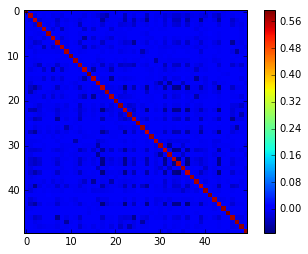

In [655]:
plt.imshow(ans[0, 56], interpolation="nearest")
plt.colorbar()

In [630]:
np.linalg.cholesky(S_un_[0, 0, :37, :37] + np.eye(37) * 0.1)

array([[  7.660e-01,   0.000e+00,   0.000e+00, ...,   0.000e+00,
          0.000e+00,   0.000e+00],
       [ -6.851e-06,   7.553e-01,   0.000e+00, ...,   0.000e+00,
          0.000e+00,   0.000e+00],
       [  7.551e-05,  -1.388e-02,   7.460e-01, ...,   0.000e+00,
          0.000e+00,   0.000e+00],
       ..., 
       [ -7.580e-05,  -1.427e-02,  -3.549e-02, ...,   7.206e-01,
          0.000e+00,   0.000e+00],
       [ -1.254e-05,  -1.238e-02,   3.159e-04, ...,   3.770e-03,
          7.527e-01,   0.000e+00],
       [  3.977e-06,  -1.349e-02,  -4.332e-02, ...,  -1.477e-01,
          3.389e-03,   7.001e-01]])

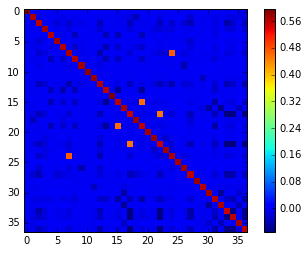

In [629]:
plt.imshow(S_un_[0, 0, :37, :37] + np.eye(37) * 0.1, interpolation="nearest")
plt.colorbar()

In [618]:
np.linalg.cholesky(S_un_[0, 0, :37, :37])

LinAlgError: Matrix is not positive definite

In [595]:
sess.close()